# Portfolio Optimization Through Divi

## Data Preparation

In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

### Loading the Raw Data

In [2]:
full_returns = np.load("1_2016-01-01_returns.npy")
correlation_matrix = np.load("1_2016-01-01_correlation.npy")
covariance_matrix = np.load("1_2016-01-01_covariance.npy")

In [3]:
scaled_full_returns = (
    MinMaxScaler().fit_transform(full_returns.reshape(-1, 1)).flatten()
)

scaled_covariance_matrix = StandardScaler().fit_transform(covariance_matrix)

scaled_correlation_matrix = MinMaxScaler().fit_transform(correlation_matrix)

### Partitioning Data

In [4]:
from modularity_spectral_partitioning import modularity_spectral_threshold
from collections import Counter

In [5]:
partitions = modularity_spectral_threshold(
    scaled_correlation_matrix, threshold=20, return_communities=False
)

partition_counts = Counter(partitions)

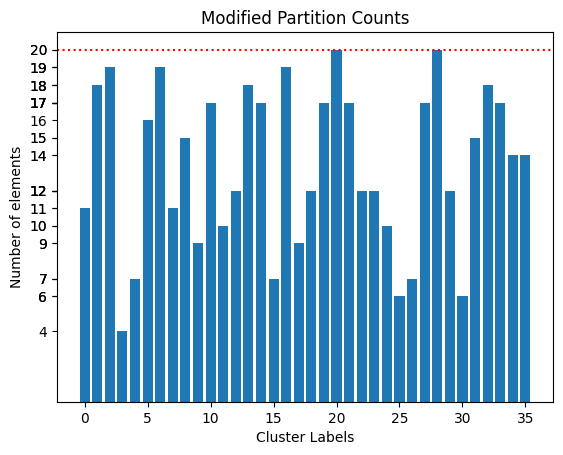

In [6]:
plt.bar(
    *list(zip(*partition_counts.items()))
)  # A little python Magic to unfurl the dictionary

plt.yticks(list(partition_counts.values()))
plt.xlabel("Cluster Labels")
plt.ylabel("Number of elements")
plt.title("Modified Partition Counts")
plt.axhline(y=20, color="r", linestyle="dotted")
plt.show()

In [7]:
partitioned_covariance_matrices = {}
partitioned_returns = {}

for cluster_label in np.unique(partitions):
    cluster_indices = np.where(partitions == cluster_label)[0]
    partitioned_covariance_matrices[cluster_label.item()] = scaled_covariance_matrix[
        np.ix_(cluster_indices, cluster_indices)
    ]
    partitioned_returns[cluster_label.item()] = scaled_full_returns[cluster_indices]

## Solving Using QAOA

In [8]:
import pennylane as qml
from pennylane import numpy as pnp
from divi.qprog import QAOA
from divi.qprog.optimizers import Optimizers

try:
    import dimod
except ImportError:
    raise ImportError(
        "This notebook requires the 'dimod' package. "
        "Please install it with:\n"
        "    pip install dimod"
    )

In [9]:
def evaluate_solution(
    partition_id: int,
    partitioned_returns_dict: dict[int, np.ndarray],
    partitioned_covariance_dict: dict[int, np.ndarray],
    qaoa_solution: np.ndarray,
):
    qubo_vector = partitioned_returns_dict[partition_id]
    qubo_matrix = partitioned_covariance_dict[partition_id]

    if np.array_equal(qubo_vector, np.diagonal(qubo_matrix)):
        np.fill_diagonal(qubo_matrix, qubo_vector)

    if not np.allclose(qubo_matrix, qubo_matrix.T):
        qubo_matrix = (qubo_matrix + qubo_matrix.T) / 2

    bqm = dimod.BinaryQuadraticModel(qubo_matrix, "BINARY")
    best_classical_bitstring, best_classical_energy, _ = (
        dimod.ExactSolver().sample(bqm).lowest().record[0]
    )

    print(f"Is Correct? {np.array_equal(best_classical_bitstring, qaoa_solution)}")
    print(f"Optimal Classical Energy: {best_classical_energy}")
    print(f"QAOA Energy: {bqm.energy(qaoa_solution)}")
    print(f"Optimal Classical Bitstring: {best_classical_bitstring}")
    print(f"QAOA Bitstring: {qaoa_solution}")

In [10]:
partition_id = 18

### PennyLane Circuit

In [11]:
def _solve_qubo(qubo_vector, qubo_matrix, depth):
    wires = range(len(qubo_vector))
    params = pnp.random.rand(2, depth)  # gamma and alpha parameters

    def circuit(params):
        # Initial State
        for w in wires:
            qml.Hadamard(wires=w)

        ##############################################

        gamma = params[0]
        alpha = params[1]

        for d in range(depth):
            # Cost Hamiltonian
            for qubit in range(len(qubo_vector)):
                theta = qubo_vector[qubit] * gamma[d]
                qml.RZ(theta, wires=qubit)

            for j in range(len(qubo_matrix)):
                for k in range(len(qubo_matrix)):
                    if j != k:
                        theta = qubo_matrix[j, k] * gamma[d]
                        qml.CRZ(theta, wires=[j, k])

            # Mixer Hamiltonian
            for qubit in range(len(qubo_vector)):
                theta = 2 * alpha[d]
                qml.RX(theta, wires=qubit)

            qml.Barrier(wires=wires)

        ##############################################

    dev = qml.device("default.qubit", wires=len(qubo_vector))

    def cost_h(qubo_vector):
        cost_h = qml.PauliZ(0)
        for i in range(1, len(qubo_vector)):
            cost_h = cost_h @ qml.PauliZ(i)
        return cost_h

    @qml.qnode(dev)
    def cost_function(params):
        circuit(params)
        return qml.expval(cost_h(qubo_vector))

    optimizer = qml.GradientDescentOptimizer()
    steps = 70

    for _ in range(steps):
        params = optimizer.step(cost_function, params)

    expected_value = cost_function(params)

    @qml.qnode(dev)
    def probability_circuit(gamma, alpha):
        circuit([gamma, alpha])
        return qml.probs(wires=wires)

    probs = probability_circuit(params[0], params[1])

    def int_to_binary(n, wires):
        return bin(n)[2:].zfill(len(wires))

    max_index = qml.numpy.argmax(probs)
    max_index_int = int(max_index)
    bit_representation = int_to_binary(max_index_int, wires)

    return bit_representation, expected_value

In [12]:
def solve_qubo_partition_pennylane(
    partition_id: int,
    partitioned_returns_dict: dict[int, np.ndarray],
    partitioned_covariance_dict: dict[int, np.ndarray],
    depth: int = 2,
):

    qubo_vector = partitioned_returns_dict[partition_id]
    qubo_matrix = partitioned_covariance_dict[partition_id]

    if np.array_equal(qubo_vector, np.diagonal(qubo_matrix)):
        np.fill_diagonal(qubo_matrix, qubo_vector)

    pl_result, pl_expval = _solve_qubo(
        qubo_vector=qubo_vector,
        qubo_matrix=qubo_matrix,
        depth=depth,
    )
    
    return pl_result, pl_expval

In [13]:
pl_solution, _ = solve_qubo_partition_pennylane(
    partition_id,
    partitioned_returns_dict=partitioned_returns,
    partitioned_covariance_dict=partitioned_covariance_matrices,
)

In [14]:
evaluate_solution(
    partition_id,
    partitioned_returns_dict=partitioned_returns,
    partitioned_covariance_dict=partitioned_covariance_matrices,
    qaoa_solution=np.fromiter(pl_solution, dtype=int),
)

Is Correct? False
Optimal Classical Energy: 0.0
QAOA Energy: 64.6085290741706
Optimal Classical Bitstring: [0 0 0 0 0 0 0 0 0 0 0 0]
QAOA Bitstring: [1 1 1 1 0 1 0 0 0 0 0 0]


### Divi API

In [15]:
def solve_qubo_partition_divi(
    partition_id: int,
    partitioned_returns_dict: dict[int, np.ndarray],
    partitioned_covariance_dict: dict[int, np.ndarray],
    depth: int = 2,
):
    qubo_vector = partitioned_returns_dict[partition_id]
    qubo_matrix = partitioned_covariance_dict[partition_id]

    if np.array_equal(qubo_vector, np.diagonal(qubo_matrix)):
        np.fill_diagonal(qubo_matrix, qubo_vector)

    qaoa_problem = QAOA(
        problem=qubo_matrix,
        n_layers=depth,
        optimizer=Optimizers.NELDER_MEAD,
        max_iterations=10,
        shots=10000,
        qoro_service=None,
    )

    qaoa_problem.run()
    qaoa_problem.compute_final_solution()

    return qaoa_problem.solution

In [16]:
divi_solution = solve_qubo_partition_divi(
    partition_id,
    partitioned_returns_dict=partitioned_returns,
    partitioned_covariance_dict=partitioned_covariance_matrices,
)

/home/shiro-raven/Desktop/Qoro/divi/divi/utils.py:238: UserWarning: The QUBO matrix is neither symmetric nor upper triangular. Symmetrizing it for the Ising Hamiltonian creation.
  warn(
2025-05-05 22:40:13,021 - divi.qprog.quantum_program - DEBUG - Finished iteration 0
2025-05-05 22:40:46,956 - divi.qprog.quantum_program - DEBUG - Finished iteration 1
2025-05-05 22:41:16,305 - divi.qprog.quantum_program - DEBUG - Finished iteration 2
2025-05-05 22:41:21,034 - divi.qprog.quantum_program - DEBUG - Finished iteration 3
2025-05-05 22:41:25,750 - divi.qprog.quantum_program - DEBUG - Finished iteration 4
2025-05-05 22:41:34,992 - divi.qprog.quantum_program - DEBUG - Finished iteration 5
2025-05-05 22:41:44,194 - divi.qprog.quantum_program - DEBUG - Finished iteration 6
2025-05-05 22:41:48,772 - divi.qprog.quantum_program - DEBUG - Finished iteration 7
2025-05-05 22:41:53,440 - divi.qprog.quantum_program - DEBUG - Finished iteration 8
2025-05-05 22:42:02,652 - divi.qprog.quantum_program - DE

In [17]:
evaluate_solution(
    partition_id,
    partitioned_returns_dict=partitioned_returns,
    partitioned_covariance_dict=partitioned_covariance_matrices,
    qaoa_solution=divi_solution,
)

Is Correct? False
Optimal Classical Energy: 0.0
QAOA Energy: 72.78368826995164
Optimal Classical Bitstring: [0 0 0 0 0 0 0 0 0 0 0 0]
QAOA Bitstring: [1 0 1 1 1 0 0 0 0 1 0 1]
